# <center>Машинное обучение</center>
<center><small>Лаборатоная работа 1</small></center>
<center><i>Решетников Андрей, 397 группа</i></center>

In [377]:
%matplotlib inline
from matplotlib import pyplot
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import ShuffleSplit
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from random import shuffle
from itertools import combinations

from os import listdir
from os.path import isfile, join

In [378]:
feature_num = 216
class_num = 6
colors = ["r", "g", "blue", "y", "black", "m"]
clasterized_sample = {x: [] for x in range(class_num)}

In [379]:
ind = 0.5
for file_name in listdir('/Users/Hoderu/Downloads/ekg-data'):
    file = open('/Users/Hoderu/Downloads/ekg-data/' + file_name)
    print(file_name)
    ind += 0.5
    for line in file.readlines():
        text_reading = list(map(int, line.split()))
        features = np.array(text_reading[1:])
        #перемешиваем данные из эталонной и обычной выборки, запоминаем больных - 1
        if text_reading[0] == 1:
            clasterized_sample[int(ind)].append(features)
        #запомнаем здоровых из первых двух файлов
        if ind < 2 and text_reading[0] == 0:
            clasterized_sample[0].append(features)

ВД.txt
ВДЭ.txt
ЖК.txt
ЖКЭ.txt
ИБ.txt
ИБЭ.txt
УЩ.txt
УЩЭ.txt
ЯБ.txt
ЯБЭ.txt


In [380]:
#по кластеризованной выборке построим некластеризованную
def declasterisation(clasterized_sample):
    X = []
    Y = []
    for i in range(class_num):
        list_example = clasterized_sample[i]
        for features in list_example:
            X.append(features)
            Y.append(i)
    #храним лист пар: набор признаков и номер класса
    li_sample = list(zip(X, Y))
    #одновременно shuffle'им
    shuffle(li_sample)
    #разархивируем
    X, Y = zip(*li_sample)
    return X, Y

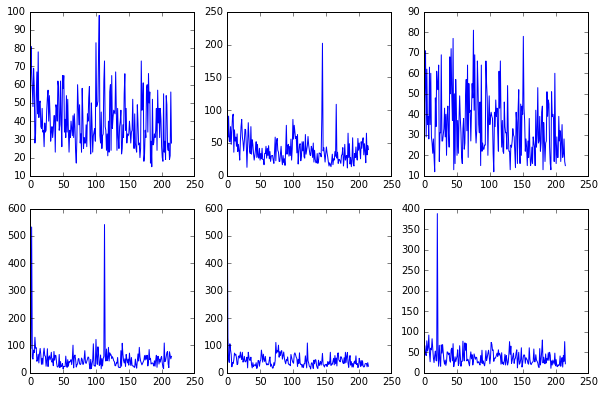

In [381]:
#Смотрим на распределение максимумов значений для каждого класса больных. 
#Как видно разброс данных большой, необходимо делать нормализацию 
pyplot.figure(figsize = (10, 10))
for i in range(class_num):
    max_m = [max((np.array(clasterized_sample[i]))[j]) for j in range(feature_num)]
    pyplot.subplot(331 + i).plot(max_m)
pyplot.show()


In [382]:
for i in range(class_num):
    #нормализуем
    clasterized_sample[i] = np.array([(np.array(clasterized_sample[i]))[j] / max((np.array(clasterized_sample[i]))[j]) for j in range(feature_num)])

In [383]:
#рисуем график для пары признаков
def plotting_pair(example, i, j, plot):
    for (features, value) in example:
        plot.scatter(features[i], features[j], color = colors[value])
    plot.set_title("features " + str(i) + " " + str(j))

In [384]:
X, Y = declasterisation(clasterized_sample)

In [385]:
#Найдем те признаки, которые суммарно у больных людей наиболее сильно отличаются от такого же признака у здоровых
features_diff_best = set()

for i in range(1, class_num):
    features_diff_best.add(np.argmax(sum(clasterized_sample[i]) - sum(clasterized_sample[0])))

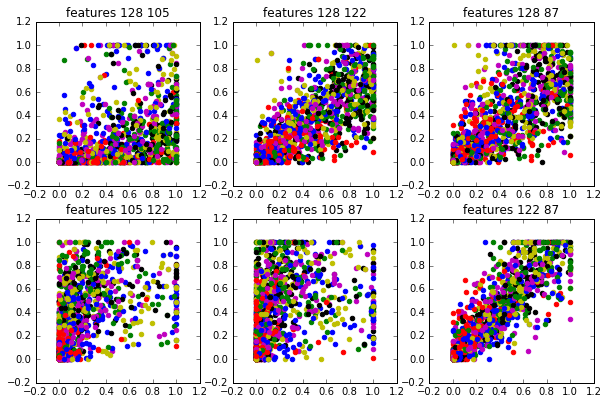

In [386]:
pyplot.figure(figsize = (10, 10))
i = 1
for x_i, y_j in combinations(features_diff_best, 2):
    plotting_pair(zip(X, Y), x_i, y_j, pyplot.subplot(330 + i))
    i += 1
pyplot.show()

Из графиков видно, что точки одного класса более-менее расположены друг рядом с другом, значит метрическая гипотеза подтверждается, но не для всех признаков.

In [387]:
#По данной паре признаков, и разбиения на тестовую, обучающую определим точность
def features_accuracy(i, j, X, Y, train_indices, test_indices):
    estimator = KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1)
    sub_X = np.asarray([np.array([features[i], features[j]]) for features in X])
    sub_Y = np.asarray(Y)
    #обучили
    estimator.fit(sub_X[train_indices], sub_Y[train_indices])
    #точность
    return estimator.score(sub_X[test_indices], sub_Y[test_indices])

In [388]:
from sklearn.cross_validation import ShuffleSplit

pairs = list(combinations(range(feature_num), 2))
shuffle(pairs)
meaning = []
#Чтобы не тратить много времени, рассмотрим 500 пар признаков
for i, j in pairs[:500]:
    #случайное разбиение на тестовую и обучающую выборки
    train_indices, test_indices = list(ShuffleSplit(len(X), test_size = 0.1))[0]
    score = features_accuracy(i, j, X, Y, train_indices, test_indices)
    meaning.append((score, i, j))

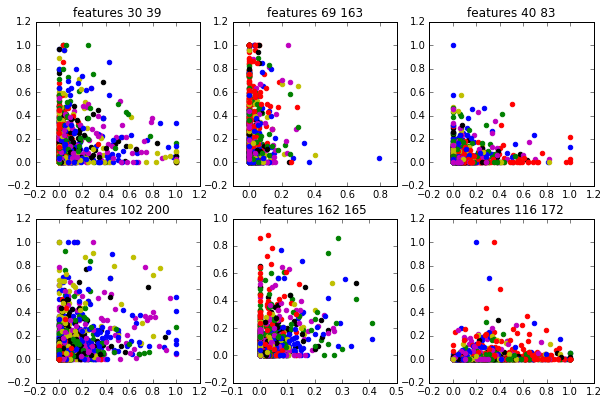

In [390]:
meaning.sort(reverse=True)
pyplot.figure(figsize = (10, 10))
i = 1
for _, x_i, y_j in meaning[:6]:
    plotting_pair(zip(X, Y), x_i, y_j, pyplot.subplot(330 + i))
    i += 1
pyplot.show()

Метрическая гипотеза опять выполняется, но можно заметить, что все еще появляются выбросы

# Задание 3

In [391]:
def final_loss_function(algorithm, x, y):
    sum = 0.0
    for i, j in zip(list(x), list(y)):
        result = algorithm(i)[0]
        if result == 0 and j != 0:
            sum += 1
        elif result != 0 and j == 0:
            sum += 0.5
        elif result != j:
            sum += 0.1
    return sum

#estimator = KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1)
#train_indices, test_indices = list(ShuffleSplit(len(X), test_size=0.1))[0]
#sub_X = np.asarray([np.array([features[104], features[164]]) for features in X])
#sub_Y = np.asarray(Y)
#estimator.fit(sub_X[train_indices], sub_Y[train_indices])
#print(final_loss_function(estimator, [[...]],[[...]]))

# Задание 4

Для данного разбиения на тестовую и обучающую выборку определим функцию подсчета значения риска

In [398]:
from sklearn.cross_validation import LeaveOneOut

def loo_error(estimator, X, Y):
    current_sum = 0
    Leave_One_Out = LeaveOneOut(len(X))
    for train, test in Leave_One_Out:
        estimator.fit(X[train], Y[train])
        predictor = lambda x: estimator.predict([x])
        current_sum += final_loss_function(predictor, X[test], Y[test])
        
    return current_sum / len(Leave_One_Out)

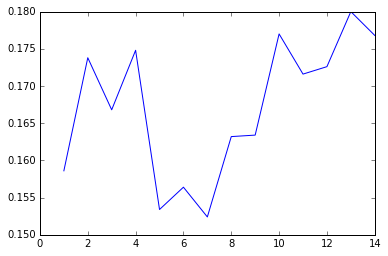

In [399]:
#Значения ошибки CV
X = np.asarray(X)[:500]
Y = np.asarray(Y)[:500]

n_values = range(1, 15)
n_error = []
for n in n_values:
    algo = KNeighborsClassifier(n_neighbors = n)
    n_error.append(loo_error(algo, X, Y))

pyplot.plot(n_values, n_error)
pyplot.show()

Оптимальное значение - 7

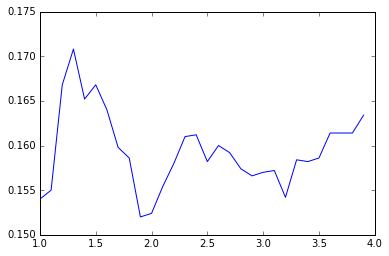

In [402]:
#Метрика Минковского
from numpy import arange

p_values = arange(1, 4, 0.1)
n_error = []

for p in p_values:
    algo = KNeighborsClassifier(n_neighbors = 7, p = p)
    n_error.append(loo_error(algo, X, Y))
    
pyplot.plot(p_values, n_error)
pyplot.show()

Оптимальное значение - 1.9

In [404]:
estimator = KNeighborsClassifier(algorithm ='brute', n_neighbors = 7, metric = 'cosine')
print(get_cv_loo_error_value(estimator, X, Y))

0.15919999999999981


Значение хуже, чем для Минковского с оптимальным значением 1.9

Рассмотрим равномерную функцию для соседей, не учитывающую расстояние

In [406]:
estimator = KNeighborsClassifier(n_neighbors = 7, p = 1.9, weights = 'uniform')
print(get_cv_loo_error_value(estimator, X, Y))

0.15199999999999994


Теперь зависящую от расстояния

In [407]:
estimator = KNeighborsClassifier(n_neighbors = 7, p = 1.9, weights = 'distance')
print(get_cv_loo_error_value(estimator, X, Y))

0.14460000000000015


Далее ближайшие соседи с экспоненциальной функцией потерь

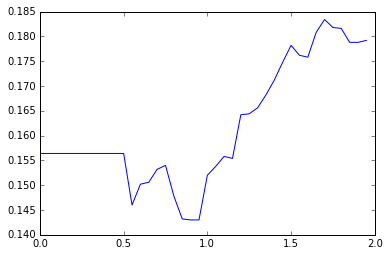

In [409]:
q_values = np.arange(0, 2, 0.05)
n_error = []

for q in q_values:
    exponential_weights = lambda distances: [q ** i for i in range(len(distances[0]))]
    algo = KNeighborsClassifier(n_neighbors = 7, p = 1.9, weights = exponential_weights)
    n_error.append(loo_error(algo, X, Y))

pyplot.plot(q_values, n_error)
pyplot.show()

График по значениям q. Оптимальное значение - 0.8

Вывод: 
Все что мы получили дает уровень ошибок, а именно:
7 ближайших соседа, 
метрика Минковского с параметром 1.9, 
равномерно взвешенные ближайшие соседи.